<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Analyzing_data_in_the_JARVIS_Leaderboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing data in [JARVIS-Leaderbaord](https://pages.nist.gov/jarvis_leaderboard/)

# Table of contents

1. Install/download JARVIS-Leaderboard
2. Example of getting data for a particular benchmark
3. List of all available benchmarks
4. Example MAEs for AI formation energy and ES silicon bandgap benchmarks as bar plots
5. Example results for AI, ES, QC and EXP results as scatter plots
6. Distribution of data in each dataset
7. MAD and MAE ratio
8. Generate bar plot figures for all benchmarks


In [1]:
import os
if not os.path.exists('jarvis_leaderboard'):
  !git clone https://github.com/usnistgov/jarvis_leaderboard.git
os.chdir('jarvis_leaderboard')
!git checkout develop
!git pull
!pip install -e .

Cloning into 'jarvis_leaderboard'...
remote: Enumerating objects: 61347, done.
remote: Counting objects: 100% (1359/1359), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 61347 (delta 648), reused 1131 (delta 434), pack-reused 59988
Receiving objects: 100% (61347/61347), 390.62 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (32070/32070), done.
Updating files: 100% (3650/3650), done.
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
Already up to date.
Obtaining file:///content/jarvis_leaderboard
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.7/975.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.7/

Example of getting data for a particular benchmark

In [2]:
from jarvis_leaderboard.rebuild import get_metric_value,get_results

In [3]:
names,vals=get_results(bench_name='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip')

In [4]:
names

array(['kgcnn_coGN', 'kgcnn_coNGN', 'potnet', 'matformer_256',
       'alignn_model', 'kgcnn_schnet', 'kgcnn_megnet', 'kgcnn_dimenetPP',
       'kgcnn_cgcnn', 'cgcnn_model', 'matminer_xgboost', 'matminer_rf',
       'matminer_lgbm', 'cfid', 'cfid_chem'], dtype='<U16')

In [5]:
vals

array([0.0271, 0.0291, 0.0293, 0.0322, 0.0331, 0.0365, 0.0423, 0.0528,
       0.0551, 0.0625, 0.0734, 0.096 , 0.1023, 0.1419, 0.2226])

List of available benchmarks

In [6]:
import glob
benchmarks = []
for i in glob.glob("jarvis_leaderboard/contributions/*/*csv.zip"):
  name = i.split("/")[-1]
  if name not in benchmarks:
    benchmarks.append(name)

print('Example 10 files', benchmarks[0:10])
print('Total', len(benchmarks))


Example 10 files ['FF-SinglePropertyPrediction-bulk_modulus_JVASP_1002_Si-dft_3d-test-mae.csv.zip', 'FF-SinglePropertyPrediction-bulk_modulus_JVASP_816_Al-dft_3d-test-mae.csv.zip', 'ES-SinglePropertyPrediction-epsx_JVASP_57_MoSe2-dft_3d-test-mae.csv.zip', 'ES-SinglePropertyPrediction-epsx_JVASP_1702_ZnS-dft_3d-test-mae.csv.zip', 'ES-SinglePropertyPrediction-epsx_JVASP_75_WSe2-dft_3d-test-mae.csv.zip', 'ES-SinglePropertyPrediction-epsx_JVASP_182_SiC-dft_3d-test-mae.csv.zip', 'ES-Spectra-dielectric_function_JVASP_1002_Si-dft_3d-test-multimae.csv.zip', 'ES-SinglePropertyPrediction-epsx_JVASP_2376_ZnSiP2-dft_3d-test-mae.csv.zip', 'ES-SinglePropertyPrediction-epsx_JVASP_2355_ZnGeP2-dft_3d-test-mae.csv.zip', 'ES-SinglePropertyPrediction-epsx_JVASP_1312_BP-dft_3d-test-mae.csv.zip']
Total 297


Example mean absolute errors for AI formation
energy and ES silicon bandgap benchmarks

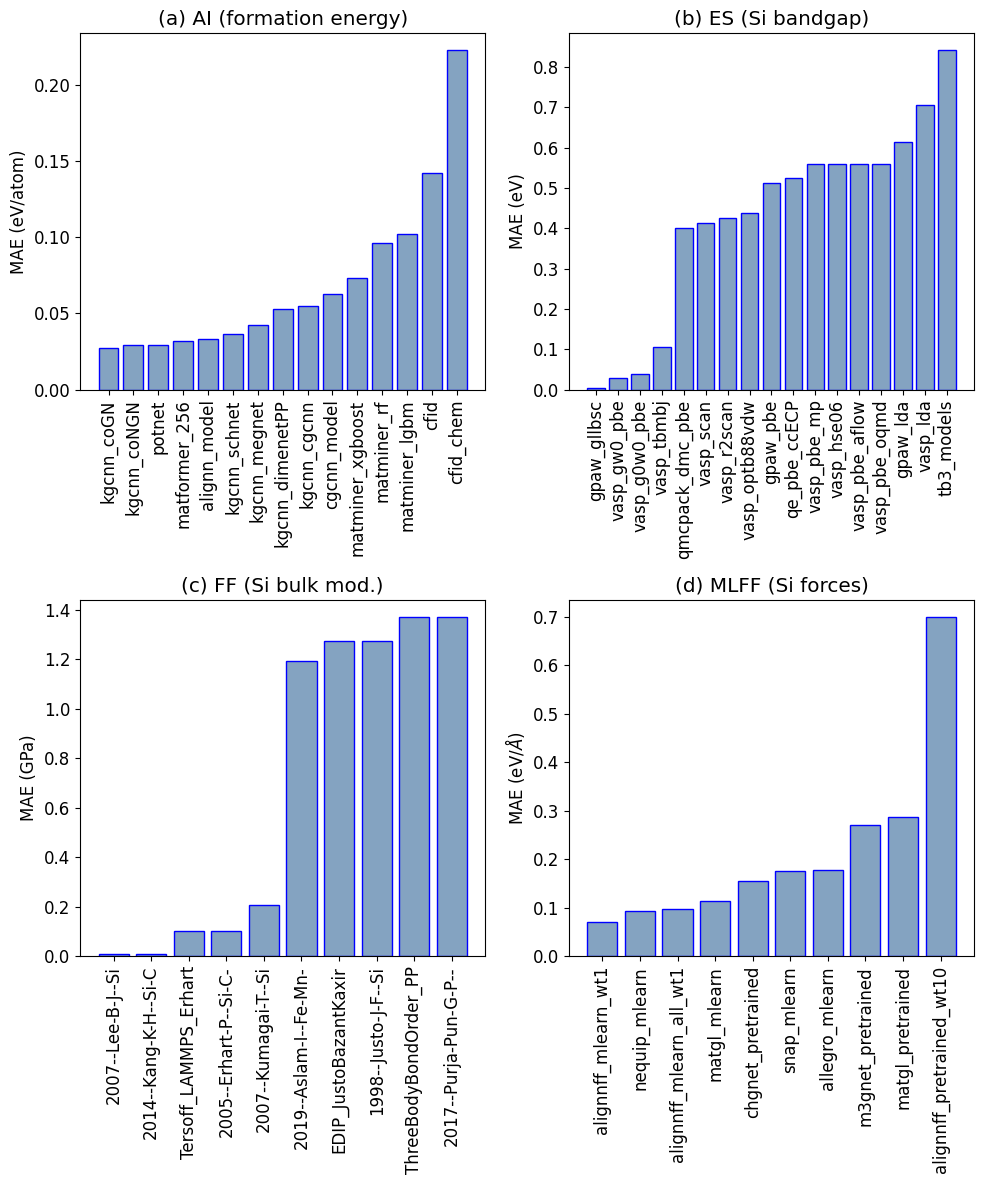

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from jarvis_leaderboard.rebuild import get_metric_value,get_results
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())
colors=np.repeat([0.1, 0.1, 0.1, 0.1],10)

the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,12))

plt.subplot(the_grid[0, 0])
names,vals=get_results(bench_name='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip')
plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6),edgecolor='blue')
plt.xticks(np.arange(len(vals)),names,rotation=90)
plt.ylabel('MAE (eV/atom)')
plt.title('(a) AI (formation energy)')

plt.subplot(the_grid[0, 1])
names,vals=get_results(bench_name='ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv.zip')
#plt.bar(np.arange(len(vals)),vals,color=colors[:len(vals)], edgecolor='blue')
plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(np.arange(len(vals)),names,rotation=90)
plt.ylabel('MAE (eV)')
plt.title('(b) ES (Si bandgap)')


plt.subplot(the_grid[1, 0])
names,vals=get_results(bench_name='FF-SinglePropertyPrediction-bulk_modulus_JVASP_1002_Si-dft_3d-test-mae.csv.zip')
names=names[2:12]
vals=vals[2:12]
names=[i.split('--LAMMPS--ipr')[0][0:21] for i in names]
plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6),edgecolor='blue')
plt.xticks(np.arange(len(vals)),names,rotation=90)
plt.ylabel('MAE (GPa)')
plt.title('(c) FF (Si bulk mod.)')

plt.subplot(the_grid[1, 1])
names,vals=get_results(bench_name='AI-MLFF-forces-mlearn_Si-test-multimae.csv.zip')
plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6),edgecolor='blue')
plt.xticks(np.arange(len(vals)),names,rotation=90)
plt.ylabel('MAE (eV/$\AA$)')
plt.title('(d) MLFF (Si forces)')


# plt.subplot(the_grid[2, 0])
# names,vals=get_results(bench_name='QC-EigenSolver-electron_bands_JVASP_816_Al_WTBH-dft_3d-test-multimae.csv.zip')
# #plt.bar(np.arange(len(vals)),vals,color=colors[:len(vals)], edgecolor='blue')
# plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
# plt.xticks(np.arange(len(vals)),names,rotation=90)
# plt.ylabel('MAE (eV)')
# plt.title('(e) QC (Al bandstruct.)')



# plt.subplot(the_grid[2, 1])
# names,vals=get_results(bench_name='AI-TextGen-text-arxiv_gen-test-rouge.csv.zip')
# #plt.bar(np.arange(len(vals)),vals,color=colors[:len(vals)], edgecolor='blue')
# plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
# names=[i.strip('transformers_')for i in names]
# plt.xticks(np.arange(len(vals)),names,rotation=90)
# plt.ylabel('ROUGE score')
# plt.title('(f) TextGen (Title to Abstract)')


plt.tight_layout()

plt.show()
#plt.savefig('MAE-updated-3.pdf')
plt.close()

In [8]:
names

['gpt2_medium_b', 'gpt2_medium_finetuned', 'ChatGPT_May23']

In [ ]:
!pwd

/content/jarvis_leaderboard


Example results for AI, ES, QC and EXP results. a) formation-energy-peratom model using AI, b) bulk modulus predictions using ES methods, c) electronic bandstructure of Al using QV methods with different quantum circuits, d) CO2 capture for zeolite at several labs in round-robin fashion.

In [ ]:
import glob
ai_form_en={}
es_kv={}
qc_eig={}
exp_co2={}
si_mlearn_forces={}
si_mlearn_energies={}
for i in glob.glob("jarvis_leaderboard/contributions/*/*.csv.zip"):

    bench_name = i.split("/")[-2]
    if i.split('/')[-1]=='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip':
        res = get_metric_value(csv_path=i)
        ai_form_en[bench_name]=res['df']

    if i.split('/')[-1]=='ES-SinglePropertyPrediction-bulk_modulus-dft_3d-test-mae.csv.zip':
    #if i.split('/')[-1]=='ES-SinglePropertyPrediction-bandgap-dft_3d-test-mae.csv.zip':
        res = get_metric_value(csv_path=i)
        es_kv[bench_name]=res['df']
    if i.split('/')[-1]=='QC-EigenSolver-electron_bands_JVASP_816_Al_WTBH-dft_3d-test-multimae.csv.zip':
        res = get_metric_value(csv_path=i)
        qc_eig[bench_name]=res['df']
    if i.split('/')[-1]=='EXP-Spectra-co2_RM_8852-nist_isodb-test-multimae.csv.zip':
        res = get_metric_value(csv_path=i)
        exp_co2[bench_name]=res['df']
    if i.split('/')[-1]=='AI-MLFF-energy-mlearn_Si-test-mae.csv.zip':
        res = get_metric_value(csv_path=i)
        si_mlearn_energies[bench_name]=res['df']
    if i.split('/')[-1]=='AI-MLFF-forces-mlearn_Si-test-multimae.csv.zip':
        res = get_metric_value(csv_path=i)
        si_mlearn_forces[bench_name]=res['df']

0 C1 #1f77b4
1 C5 #ff7f0e
2 C3 #2ca02c
3 C2 #d62728
4 C6 #9467bd
5 C4 #8c564b


<ipython-input-10-bd4fab5984f8>:85: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


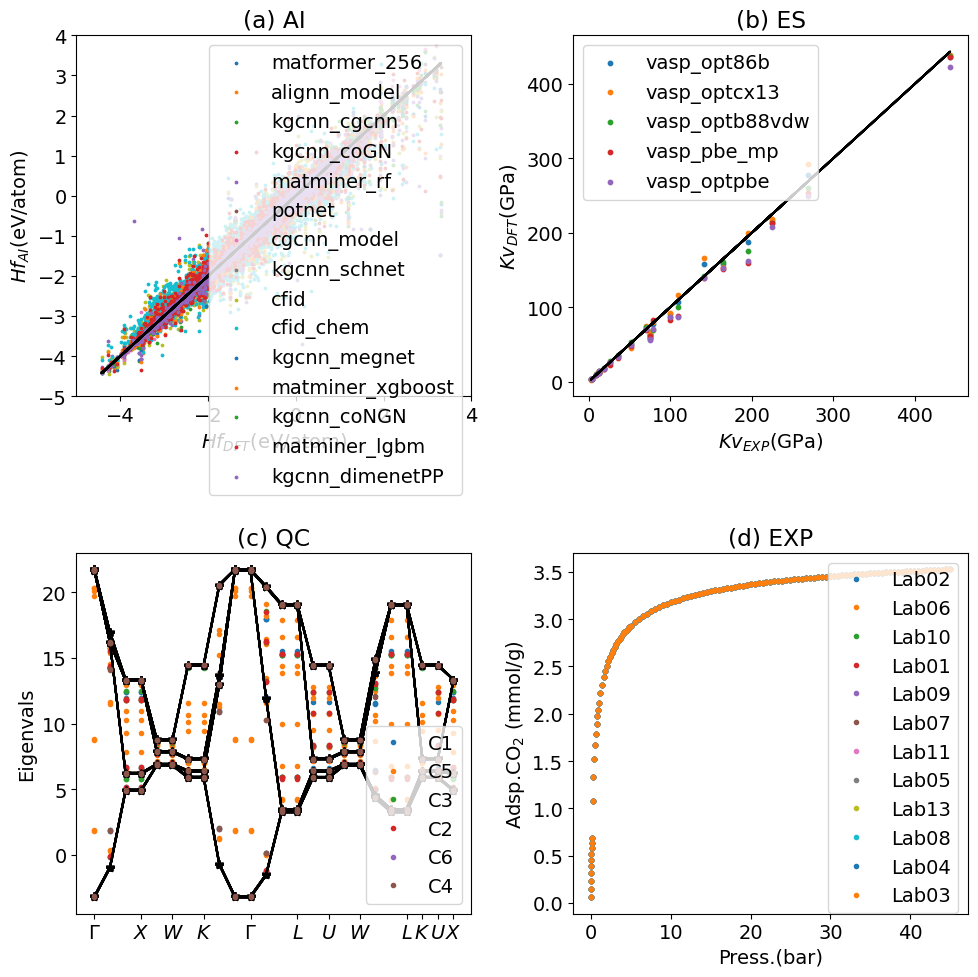

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,10))

plt.subplot(the_grid[0, 0])
plt.xlabel('$Hf_{DFT}$(eV/atom)')
plt.ylabel('$Hf_{AI}$(eV/atom)')
plt.title('(a) AI')
for i,j in ai_form_en.items():
    plt.scatter(j['actual'],j['prediction'],s=3,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()
plt.xlim([-5,4])
plt.ylim([-5,4])

plt.subplot(the_grid[0, 1])
plt.title('(b) ES')
plt.ylabel('$Kv_{DFT}$(GPa)')
plt.xlabel('$Kv_{EXP}$(GPa)')
for i,j in es_kv.items():
    plt.scatter(j['actual'],j['prediction'],s=10,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()



plt.subplot(the_grid[1, 0])

count=0
colors = list(mcolors.TABLEAU_COLORS.values())
for i,j in qc_eig.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float').reshape(24,8)
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float').reshape(24,8)

    for ii,jj in enumerate(actual.T):
#         if ii==0:
#             plt.plot(jj,'-*',c='g',label='NP')
        plt.plot(jj,'-*',c='black')

    for ii,jj in enumerate(pred.T):
#         if ii==0:
#             plt.plot(jj,'*',c='b',label=i.split('qiskit_vqd_SU2_')[1])
        if ii==0:
            lbl = i.split('qiskit_vqd_SU2_')[1].replace('c','C')


            plt.plot(jj,'.',label=lbl,c=colors[count])
            print(count,lbl,colors[count])

        else:
            plt.plot(jj,'.',c=colors[count])
    count+=1

kp=[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]
lbls=['$\\Gamma$', '$X$', '$W$', '$K$', '$\\Gamma$', '$L$', '$U$', '$W$', '$L$', '$K$', '$U$', '$X$']
plt.xticks(kp,lbls)
plt.legend(loc='lower right')
plt.title('(c) QC')
plt.ylabel('Eigenvals')



plt.subplot(the_grid[1, 1])

press=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5, 40, 40.5, 41, 41.5, 42, 42.5, 43, 43.5, 44, 44.5, 45]

for i,j in exp_co2.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float')
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float')
    #press=np.log(press)
#     pred=np.exp(pred)
#     actual=np.exp(actual)
    plt.plot(press,actual,'.',label=i.split('x.')[-1])
plt.legend()
plt.title('(d) EXP')
plt.xlabel('Press.(bar)')
plt.ylabel('Adsp.CO$_2$ (mmol/g)')


plt.tight_layout()
plt.show()
# plt.savefig('results_example.pdf')
# plt.close()

Machine learning force fields Si-Mlearn

In [ ]:
si_mlearn_forces.keys()

dict_keys(['matgl_pretrained', 'allegro_mlearn', 'chgnet_pretrained', 'snap_mlearn', 'm3gnet_pretrained', 'matgl_mlearn', 'alignnff_pretrained_wt10', 'alignnff_mlearn_all_wt1', 'alignnff_mlearn_wt1'])

0.06942387617720659


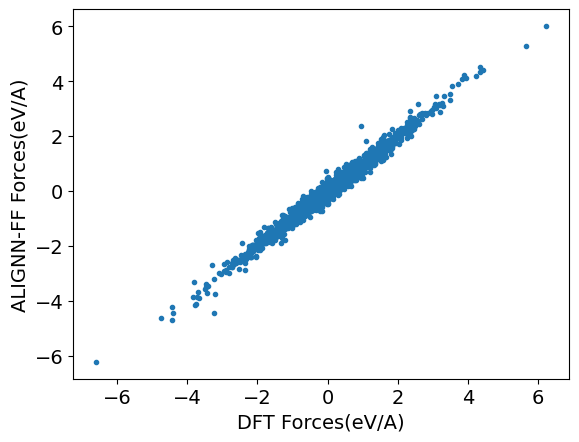

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
x_alignnff_mlearn_wt1 = np.concatenate(si_mlearn_forces['alignnff_mlearn_wt1']['actual'].apply(lambda x:np.array(x.split(';'),dtype='float')).values)
y_alignnff_mlearn_wt1 = np.concatenate(si_mlearn_forces['alignnff_mlearn_wt1']['prediction'].apply(lambda x:np.array(x.split(';'),dtype='float')).values)
plt.plot(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1,'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('ALIGNN-FF Forces(eV/A)')
print(mean_absolute_error(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1))

0.17593393432121426


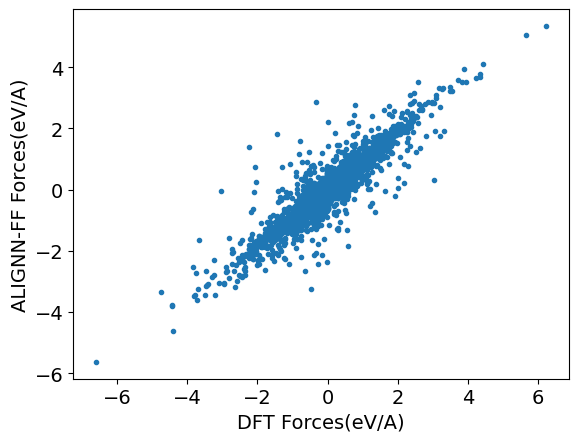

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
x_alignnff_mlearn_wt1 = np.concatenate(si_mlearn_forces['snap_mlearn']['actual'].apply(lambda x:np.array(x.split(';'),dtype='float')).values)
y_alignnff_mlearn_wt1 = np.concatenate(si_mlearn_forces['snap_mlearn']['prediction'].apply(lambda x:np.array(x.split(';'),dtype='float')).values)
plt.plot(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1,'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('ALIGNN-FF Forces(eV/A)')
print(mean_absolute_error(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1))

In [ ]:
import glob
from jarvis_leaderboard.rebuild import get_metric_value,get_results
for ii in glob.glob('jarvis_leaderboard/contributions/alignnff_mlearn_wt1/*.csv.zip'):
  #if 'multimae' in ii:
     bname=ii.split('/')[-1]
     print(bname)
     names,vals=get_results(bench_name=bname)
     for i,j in zip(names,vals):
         print(i,j)
     print()
     print()

AI-MLFF-forces-mlearn_Ge-test-multimae.csv.zip
snap_mlearn 0.0983
alignnff_mlearn_combined 0.1407
chgnet_pretrained 0.1629
alignnff_mlearn_wt1 0.2791
matgl_pretrained 0.2887
m3gnet_pretrained 0.3485
alignnff_pretrained_wt10 0.4113


AI-MLFF-stresses-mlearn_Ni-test-multimae.csv.zip
matgl_pretrained 38.8421
alignnff_mlearn_wt1 54.3938
alignnff_mlearn_combined 66.0606


AI-MLFF-stresses-mlearn_Cu-test-multimae.csv.zip
matgl_pretrained 29.0813
matgl_mlearn 29.8964
alignnff_mlearn_combined 38.5009
alignnff_mlearn_wt1 44.7444


AI-MLFF-stresses-mlearn_Si-test-multimae.csv.zip
matgl_pretrained 12.3679
matgl_mlearn 12.9778
alignnff_mlearn_combined 17.3159
alignnff_mlearn_wt1 27.1211


AI-MLFF-energy-mlearn_Cu-test-mae.csv.zip
matgl_mlearn 0.8696
alignnff_mlearn_combined 1.0104
m3gnet_pretrained 1.1195
snap_mlearn 1.4912
alignnff_mlearn_wt1 1.5529
chgnet_pretrained 2.9263
matgl_pretrained 3.6418


AI-MLFF-forces-mlearn_Cu-test-multimae.csv.zip
matgl_mlearn 0.018
alignnff_mlearn_wt1 0.019
alignn

0.17593393432121426


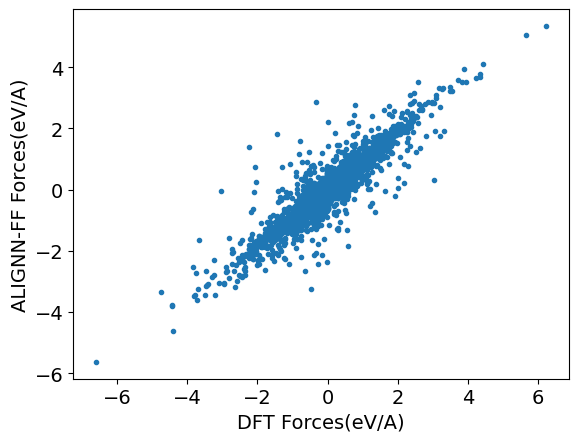

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
x_alignnff_mlearn_wt1 = np.concatenate(si_mlearn_forces['snap_mlearn']['actual'].apply(lambda x:np.array(x.split(';'),dtype='float')).values)
y_alignnff_mlearn_wt1 = np.concatenate(si_mlearn_forces['snap_mlearn']['prediction'].apply(lambda x:np.array(x.split(';'),dtype='float')).values)
plt.plot(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1,'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('ALIGNN-FF Forces(eV/A)')
print(mean_absolute_error(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1))

1.1766097253153232


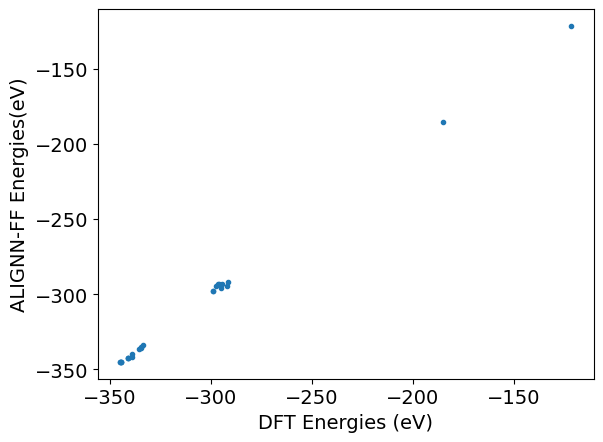

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
x_alignnff_mlearn_wt1 =(si_mlearn_energies['alignnff_mlearn_wt1']['actual'].values)
y_alignnff_mlearn_wt1 = (si_mlearn_energies['alignnff_mlearn_wt1']['prediction'].values)
plt.plot(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1,'.')
plt.xlabel('DFT Energies (eV)')
plt.ylabel('ALIGNN-FF Energies(eV)')
print(mean_absolute_error(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1))

1.1141420084634666


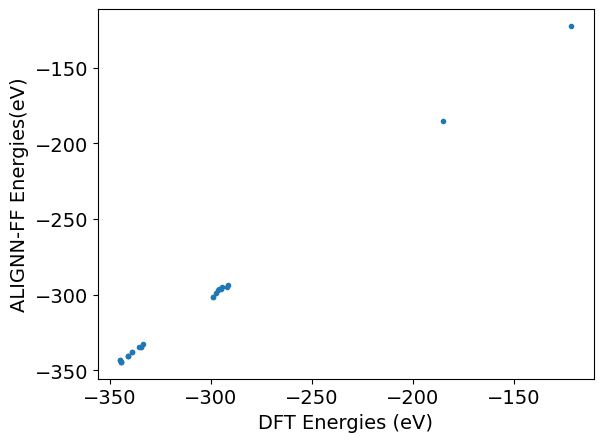

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
x_alignnff_mlearn_wt1 =(si_mlearn_energies['snap_mlearn']['actual'].values)
y_alignnff_mlearn_wt1 = (si_mlearn_energies['snap_mlearn']['prediction'].values)
plt.plot(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1,'.')
plt.xlabel('DFT Energies (eV)')
plt.ylabel('ALIGNN-FF Energies(eV)')
print(mean_absolute_error(x_alignnff_mlearn_wt1,y_alignnff_mlearn_wt1))

Distribution of data in each dataset. a) all entries in leaderboard, b) entries with unique identifiers. Note one identifier can have multiple properties.

In [ ]:
import glob
import zipfile
import numpy as np
import json,os
from jarvis.db.jsonutils import loadjson
from collections import defaultdict
import pandas as pd
from sklearn.metrics import mean_absolute_error, accuracy_score


id_info = defaultdict()
for csv_path in glob.glob("jarvis_leaderboard/contributions/*/*.csv.zip"):

    fname = csv_path.split("/")[-1].split(".csv.zip")[0]
    contribution = csv_path.split("/")[-2]
    temp = fname.split("-")
    category = temp[0]
    subcat = temp[1]
    prop = temp[2]
    dataset = temp[3]
    data_split = temp[4]
    metric = temp[-1]



    data_split='test'
    json_name = dataset + "_" + prop + ".json"
    json_path = 'jarvis_leaderboard/benchmarks/'+category+'/'+subcat+'/'+json_name+'.zip'
    z = zipfile.ZipFile(json_path)
    json_data = json.loads(z.read(json_name))
    if dataset not in id_info:
        id_info[dataset]=[]


    if "val" in json_data:  # sometimes just train-test
        data_size = (
            len(json_data["train"])
            + len(json_data["val"])
            + len(json_data["test"])
        )
        for m in list(json_data["train"].keys()):

                id_info[dataset].append(m)
        for m in list(json_data["val"].keys()):

                id_info[dataset].append(m)
        for m in list(json_data["test"].keys()):

                id_info[dataset].append(m)
    else:
        data_size = len(json_data["train"]) + len(json_data["test"])
        for m in list(json_data["train"].keys()):

                id_info[dataset].append(m)

        for m in list(json_data["test"].keys()):

                id_info[dataset].append(m)

dft_3d 9870680 55880
mlearn_Si 6453 239
mlearn_Mo 2821 217
mlearn_Ge 3289 253
mlearn_Li 3510 270
mlearn_Cu 4102 293
mlearn_Ni 4410 294
vacancydb_elements 74 74
vacancydb 569 530
alignn_ff_db 1842666 307111
vacancydb_oxides 65 65
vacancydb_2D 72 72
mat_scholar_ner 123267 123267
nist_isodb 12 1
qm9_std_jctc 1569948 130829
hmof 2890671 137651
megnet 415434 69239
qe_tb 15761906 829574
halide_peroskites 1145 229
AGRA_O 1000 1000
edos_pdos 14243 14243
tinnet_O 745 745
AGRA_COOH 280 280
ocp_all 1020428 510214
tinnet_OH 746 746
AGRA_CHO 214 214
AGRA_CO 193 193
ocp10k 179658 59886
ocp100k 449658 149886
tinnet_N 327 327
snumat 31158 10386
AGRA_OH 875 875
qmof 61272 20424
midas 5 1
arxiv_gen 1470 490
biobench 9 3
mag2d_chem 2486 226
ssub 18986 1726
supercon_chem 180554 16414
lj_2d_liquid 2 1
pubchem 400500 44500
arXiv 908946 87148
dft_2d 2 2
carbon24 10153 10153
perov5 18928 18928
mxene275 274 274
arxiv_summary 87148 87148
stem_2d_image 18300 9150
vacancydb_oxides_train_test 30 30


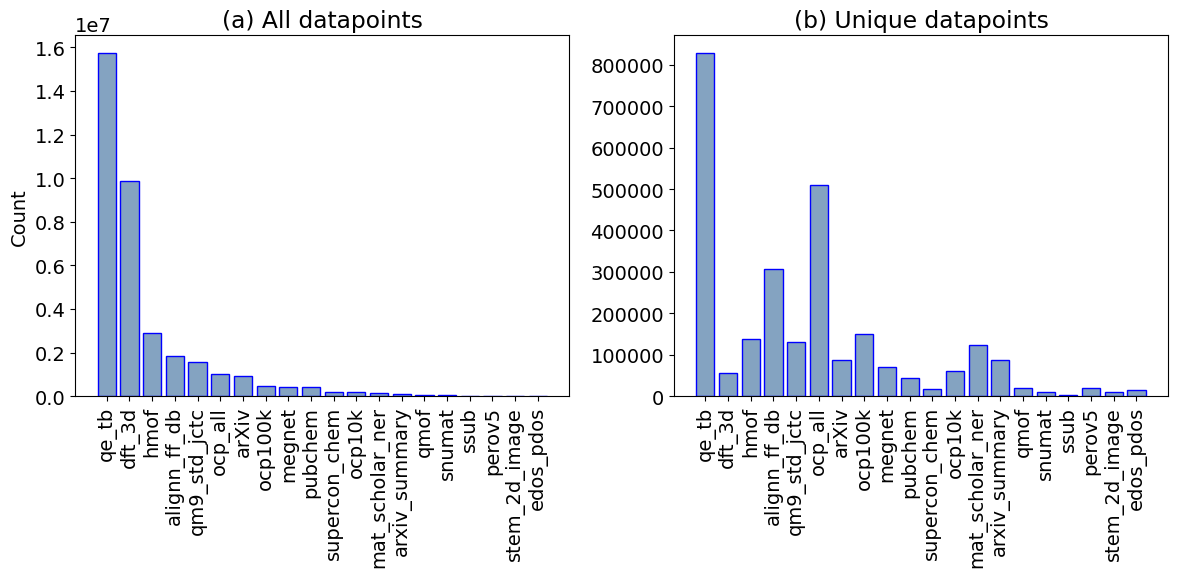

In [ ]:
import numpy as np
names=[]
all_ids=[]
unique_ids=[]
for i,j in id_info.items():
    print (i,len(j),len(set(j)))
    names.append(i)
    all_ids.append(len(j))
    unique_ids.append(len(set(j)))


take=20
order = np.argsort(all_ids)[::-1]
names=np.array(names)[order][0:take]
all_ids=np.array(all_ids)[order][0:take]
unique_ids=np.array(unique_ids)[order][0:take]
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(1, 2)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,6))

plt.subplot(the_grid[0, 0])
plt.title('(a) All datapoints')
plt.ylabel('Count')

#plt.bar(names,all_ids,facecolor = '#2ab0ff', edgecolor='b',alpha=0.7)
plt.bar(names,all_ids,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(rotation=90)
plt.subplot(the_grid[0, 1])
plt.title('(b) Unique datapoints')
#plt.bar(names,unique_ids,facecolor = '#2ab0ff', edgecolor='b',alpha=0.7)
plt.bar(names,unique_ids,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
# plt.savefig('data_dist.pdf')
# plt.close()

Mean absolute deviation to mean absolute ratio, MAD and MAE for a) AI and b) electronic structure methods. MAD:MAE serves as uniform criteria for comparing performances of models.

54

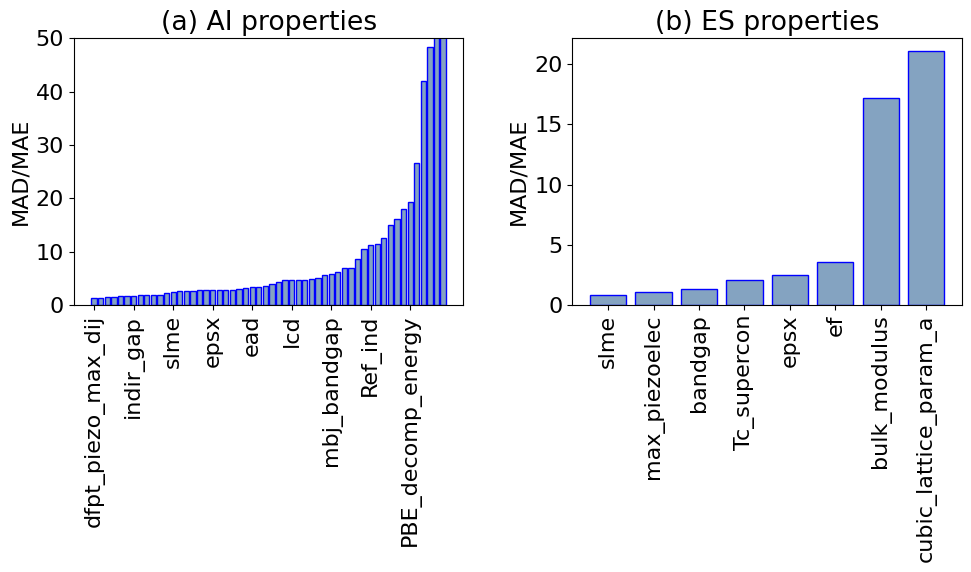

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

the_grid = GridSpec(1, 2)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,6))

plt.subplot(the_grid[0, 0])
plt.title('(a) AI properties')
plt.ylabel('MAD/MAE')

mad_maes=[]
mad_maes_names=[]
ai_single_prop = []
for i in glob.glob("jarvis_leaderboard/contributions/*/AI-SinglePropertyPrediction*.csv.zip"):
    nm=i.split('/')[-1].split('-')[2].replace('optb88vdw','OPT')
    if 'qm9' not in i and nm not in mad_maes_names: #requires scaling factor
        tmp= i.split('/')[-1]
        res=get_metric_value(i)
        random_guessing_performance=res['random_guessing_performance']
        mae=res['res']
        mad_mae = random_guessing_performance/mae
        mad_maes.append(mad_mae)
        mad_maes_names.append(nm)
        #break
        if tmp not in ai_single_prop:
            ai_single_prop.append(tmp)
mad_maes=np.array(mad_maes)
mad_maes_names=np.array(mad_maes_names)
order=np.argsort(mad_maes)
mad_maes=mad_maes[order]
mad_maes_names=mad_maes_names[order]

back=mad_maes_names
plt.subplot(the_grid[0, 0])
plt.bar(np.arange(len(mad_maes)),mad_maes,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.ylim([0,50])
plt.xticks(np.arange(len(mad_maes)),mad_maes_names,rotation=90)
plt.locator_params(axis='x', nbins=10)




plt.subplot(the_grid[0, 1])
plt.title('(b) ES properties')
plt.ylabel('MAD/MAE')
mad_maes=[]
mad_maes_names=[]
es_single_prop = []
for i in glob.glob("jarvis_leaderboard/contributions/*/ES-SinglePropertyPrediction*.csv.zip"):
    nm=i.split('/')[-1].split('-')[2]
    if 'JVASP' not in i and nm not in mad_maes_names: #single data
        tmp= i.split('/')[-1]
        res=get_metric_value(i)
        random_guessing_performance=res['random_guessing_performance']
        mae=res['res']
        mad_mae = random_guessing_performance/mae
        mad_maes.append(mad_mae)
        mad_maes_names.append(nm)
        #break
        if tmp not in es_single_prop:
            es_single_prop.append(tmp)
mad_maes=np.array(mad_maes)
mad_maes_names=np.array(mad_maes_names)
order=np.argsort(mad_maes)
mad_maes=mad_maes[order]
mad_maes_names=mad_maes_names[order]

len(es_single_prop)




plt.bar(np.arange(len(mad_maes)),mad_maes,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
plt.xticks(np.arange(len(mad_maes)),mad_maes_names,rotation=90)
plt.locator_params(axis='x', nbins=8)

#plt.ylim([0,100])
plt.tight_layout()
len(ai_single_prop)

Generate figures for all benchmarks

In [ ]:
!pip install -q pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 22.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 40.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confli

Supplementary information

In [ ]:
%%time
#Supplementary information plot with more than 274 figures!
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 7})

count = 0
with PdfPages('jarvis_leaderboard_benchmarks.pdf') as pdf:
    plt.figure(figsize=(6, 6))
    for i in benchmarks:
      names,vals=get_results(bench_name=i)
      plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
      plt.xticks(np.arange(len(vals)),names,rotation=90)
      title = 'Fig S'+str(count+1)+':'+i
      count+=1
      plt.title(title)
      metric = (i.split('.csv.zip')[0].split('-')[-1]).upper()
      plt.ylabel(metric)
      plt.tight_layout()
      pdf.savefig()  # saves the current figure into a pdf page
      plt.close()




    d = pdf.infodict()
    d['Title'] = 'Multipage PDF Example'
    d['Author'] = 'NIST-JARVIS'
    d['Subject'] = 'How to create a multipage pdf file and set its metadata for JARVIS-Leaderboard'
    d['Keywords'] = 'PdfPages multipage keywords author title subject'
    d['CreationDate'] = datetime.datetime(2009, 11, 13)
    d['ModDate'] = datetime.datetime.today()
#To see/download the generated pdf, navigate to 'Files'>'jarvis_leaderboard' folder (on the left side of the notebook with folder icon)


<timed exec>:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
<timed exec>:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


rouge scores 0.2035984734708006
rouge scores 0.24134265885953154
rouge scores 0.30057463999458794
AtomGen
AtomGen
AtomGen
rouge scores 0.2601934249249163
CPU times: user 50min 24s, sys: 40min 49s, total: 1h 31min 14s
Wall time: 53min 32s


In [ ]:
print(count)

In [ ]:
# The baseline model to be compared
base_model = 'matminer'

def get_df(file,filetype):
    # Open the zip file
    with zipfile.ZipFile(file, 'r') as zip_file:
        # Read the CSV file from the zip into memory
        csv = zip_file.namelist()[0]
        with zip_file.open(csv) as csv_file:
            # Convert the CSV file in memory to a DataFrame
            if filetype == 'csv':
                df = pd.read_csv(io.TextIOWrapper(csv_file))
            elif filetype == 'json':
                df = pd.read_json(io.TextIOWrapper(csv_file))
    # df = df.set_index(df.columns[0])
    return df

# Calculate the relative performance

In [ ]:
import pandas as pd
import numpy as np
import io
import zipfile
import glob
import os
os.chdir("/content/jarvis_leaderboard/jarvis_leaderboard/contributions/matminer_xgboost")

scores = {}
ratio = {}
best_model={} # best NN models

# loop over all the zip files in the folder
for file in glob.glob("AI-SinglePropertyPrediction-*.zip"):

    filename_split = file.split('-')
    benchmark_name = f'{filename_split[3]}_{filename_split[2]}'

    # if benchmark_name == 'ssub_formula_energy':
    #     continue # skip this benchmark

    file_benchmark = (f'../../benchmarks/{filename_split[0]}/{filename_split[1]}/'
                      +benchmark_name+'.json.zip')
    df_test = get_df(file_benchmark,filetype='json')
    y_test = df_test['test'].dropna().sort_index()

    scores[benchmark_name] = pd.Series(dtype=float)
    for contri in glob.glob("../*/"+file):
        name = contri.split('/')[1]
        df = get_df(contri,filetype='csv')
        df = df.set_index('id').sort_index()
        y_pred = df.loc[y_test.index,'prediction']
        # get the MAE
        scores[benchmark_name][name] = np.mean(np.abs(y_test-y_pred))

    # sort the scores
    scores[benchmark_name] = scores[benchmark_name].sort_values()

    # iterate over rows of scores[benchmark_name]
    best = 0
    for i, row in scores[benchmark_name].items():
        # if base_model not in i:
        if 'nn' in i or 'Net' in i:
            best = row
            best_model[benchmark_name] = i
            break

    for i, row in scores[benchmark_name].items():
        if base_model in i:
            best_matminer = row
            break

    if best == 0:
        ratio[benchmark_name] = np.nan
    else:
        ratio[benchmark_name] = round((best_matminer/best - 1)*100,1)

# Plot the relative performance

<ipython-input-33-fa6d907c8916>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ratios[ratios.columns[0]], y=ratios.index, data=ratios, palette="Blues_r_d")


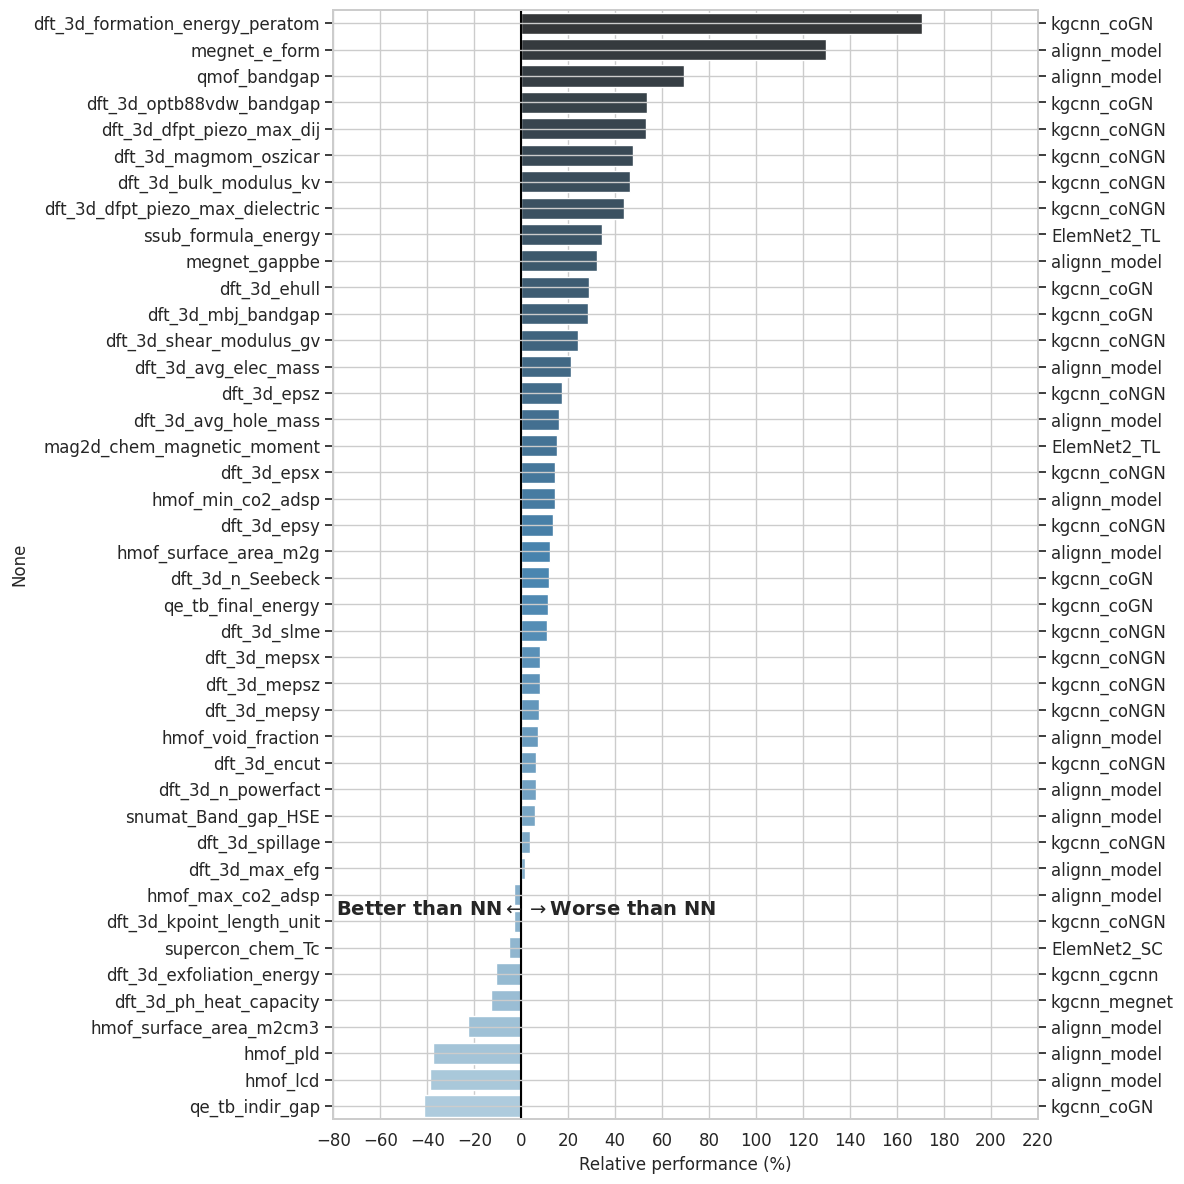

In [ ]:
# set the font size
fontsize = 12

ratio = pd.Series(ratio)
best_model = pd.Series(best_model) # best excluding matminer
ratios = pd.concat([ratio,best_model],axis=1).sort_values(by=0,ascending=False)

# get the rows of ratios whose first column value is smaller than 30
threshold = 220
ratios = ratios[ratios[ratios.columns[0]]<threshold]


# plot ratios (don't use seaborn)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))
# set xticks
ax.set_xticks(np.arange(-80,threshold+20,20))
# set xlim
ax.set_xlim(-80,threshold)
ax = sns.barplot(x=ratios[ratios.columns[0]], y=ratios.index, data=ratios, palette="Blues_r_d")
ax.set(xlabel='Relative performance (%)', #ylabel='AI benchmark', #title='Degradation of Matminer'
       )
# # rotate the xticklabels
# ax.set_yticklabels(ax.get_yticklabels(), rotation=10)

# add ratios[ratios.columns[0]] as the right y-axis ticklabels
# make sure the two y-axes have the same ticks
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(ax.get_yticks())
yticklabels = ratios[ratios.columns[1]].tolist()
ax2.set_yticklabels(yticklabels,fontsize=fontsize)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

# add a vertical line at x=0
ax.axvline(x=0,linestyle='-',color='black')
# ax.axvline(x=20,linestyle='-',color='black')
# # add text
ax.text(2,33.75,r'$\rightarrow$Worse than NN',fontsize=fontsize+2,fontweight='bold')
ax.text(-79,33.75,r'Better than NN$\leftarrow$',fontsize=fontsize+2,fontweight='bold')
plt.tight_layout()
# save to pdf
plt.savefig('matminer_performance.pdf',dpi=300)



In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.19.1
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.3
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorama==0.4.6
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==41.0.7
cufflinks==0.17.3
cupy-cuda12x==12.2.0
cvxo